# Load Libraries

In [1]:
import sys
import math
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import re
import glob as g
import gc
from scipy import stats 
from matplotlib.ticker import AutoMinorLocator

In [2]:
from scipy.optimize import curve_fit

# Functions

In [3]:
def mindist(sel1, sel2):
    list_o_dist = []
    for a in sel1:
        for b in sel2:
            p1 = a.position
            p2 = b.position
            dist = math.sqrt((p2[2]-p1[2])**2+(p2[1]-p1[1])**2+(p2[0]-p1[0])**2)
            list_o_dist.append(dist)
    return min(list_o_dist)

# Paths, pHs, and Stages

In [4]:
phs = [4.5, 5.0, 5.5]

# Load Lig Up/Down and D214 fSASA Data

This data has been autoimaged so the ligand is always placed in the pocket and all PBC issues are fixed. 

In [5]:
lig_path = 'data/raw_Lig_UpDown_data'
lig_data = []
for n, ph in enumerate(phs):
    data_sub = []
    with open('{}/pH_{}.dat'.format(lig_path, ph), 'r') as f:
        for line in f:
            if "#" not in line:
                split_line = re.split('\s+', line)
                split_line = split_line[:-1]
                data_sub.append(float(split_line[0]))
    lig_data.append(data_sub)

In [6]:
sasa_path = 'data/raw_D214_sasa_holo_data'
sasa_data = []
for n, ph in enumerate(phs):
    data_sub = []
    with open('{}/sasa_{}.dat'.format(sasa_path, n), 'r') as f:
        for line in f:
            if "#" not in line:
                split_line = re.split('\s+', line)
                split_line = split_line[1:-1]
                data_sub.append(float(split_line[1]))
    sasa_data.append(data_sub)

In [7]:
data_remake = []
for n, ph in enumerate(phs):
    for d1, d2 in zip(lig_data[n], sasa_data[n]):
        data_remake.append([d1, d2/92.6867])

# Plot Data

In [8]:
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['xtick.major.size'] = 4
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.major.size'] = 4
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['ytick.minor.size'] = 2
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['savefig.pad_inches'] = 0

In [9]:
ink_x = 1.4 # 1.5
ink_y = 1.2 # 1.5

## With Labels

In [10]:
# Taken From: https://towardsdatascience.com/beautiful-custom-colormaps-with-matplotlib-5bab3d1f0e72
def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]

def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = mcolors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)

    return cmp

In [11]:
#test = get_continuous_cmap(['#FFFFFF', '#FF2D97', '#FE2DFF', '#952DFF', '#2D2EFF', '#2D97FF', '#2DFFFE'])

In [12]:
blues = get_continuous_cmap(['#FFFFFF', '#2D97FF', '#2DFFFE'])

In [13]:
# Fold Cell
plt.close('all')

figrows = 1
figcols = 1
fig, axes = plt.subplots(nrows = figrows, ncols = figcols, figsize= (5, 5))
fig.set_facecolor('white')

# Get Data Points
nbins = 40
x = [x[0] for x in data_remake]
y = [y[1] for y in data_remake]
#axes.plot(x, y, '.')

kde = stats.gaussian_kde([x, y])

xx, yy = np.mgrid[0:15:(15-0)/nbins, 
                  0:1:(1)/nbins]

density = ((kde(np.c_[xx.flat, yy.flat].T))).reshape(xx.shape)

# Plot Surface
cset = axes.contourf(xx, yy, density, 40, cmap=blues, vmax=0.6)
#plt.colorbar()
# Remove Lowest Level
cset.collections[0].remove()


# Plot Details
axes.set_xlabel('Pepstatin Pose [$\AA$]', fontsize=15)
axes.set_xlim(2, 14)
axes.set_xticks([2, 6, 10, 14])
#axes.xaxis.set_minor_locator(AutoMinorLocator(2))

axes.set_ylabel('fSASA [$\AA^2$]', fontsize=15)
axes.set_ylim(0, 0.6)
axes.set_yticks([0, 0.3, 0.6])
#axes.yaxis.set_minor_locator(AutoMinorLocator(2))

plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

axes.spines['right'].set_visible(False)
axes.spines['top'].set_visible(False)

fig.tight_layout()
#plt.savefig('temp.pdf')
plt.show()

## Without Labels

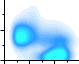

In [14]:
# Fold Cell
plt.close('all')

figrows = 1
figcols = 1
fig, axes = plt.subplots(nrows = figrows, ncols = figcols, figsize=(ink_x, ink_y))
fig.set_facecolor('white')

# Get Data Points
nbins = 40
x = [x[0] for x in data_remake]
y = [y[1] for y in data_remake]

kde = stats.gaussian_kde([x, y])

xx, yy = np.mgrid[0:15:(15-0)/nbins, 
                  0:1:(1)/nbins]

density = ((kde(np.c_[xx.flat, yy.flat].T))).reshape(xx.shape)

# Plot Surface
cset = axes.contourf(xx, yy, density, 40, cmap=blues, vmax=0.6)
#plt.colorbar()
# Remove Lowest Level
cset.collections[0].remove()
# Salt-Bridge Cutoff Line
#axes.hlines(3.5, 0, 1, colors='Black', )


# Plot Details
axes.set_xlim(2, 14)
axes.set_xticks([2, 6, 10, 14])
axes.xaxis.set_minor_locator(AutoMinorLocator(2))
axes.tick_params(labelleft=False)

axes.set_ylim(0, 0.6)
axes.set_yticks([0, 0.3, 0.6])
axes.yaxis.set_minor_locator(AutoMinorLocator(2))
axes.tick_params(labelbottom=False)


axes.spines['right'].set_visible(False)
axes.spines['top'].set_visible(False)

fig.tight_layout()
plt.savefig('plots/Lig_updown_vs_fSASA_HM.png', dpi=360, transparent=True)
plt.show()